# Local self-attention (answer)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch.nn.modules.linear import Linear
import torch.nn as nn
from torchsummary import summary
import math

## LocalSelfAttention module

In [2]:
class LocalSelfAttention(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0, bias=False):
        super(LocalSelfAttention, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        
        assert out_channels % 2 == 0
        
        self.rel_h = nn.Parameter(torch.randn(out_channels // 2, 1, 1, kernel_size, 1), requires_grad=True)
        self.rel_w = nn.Parameter(torch.randn(out_channels // 2, 1, 1, 1, kernel_size), requires_grad=True)
        
        self.key_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.query_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.value_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        
    def forward(self, x):
        batch, channels, height, width = x.size()
        
        padded_x = F.pad(x, [self.padding, self.padding, self.padding, self.padding])
        q_out = self.query_conv(x)
        k_out = self.key_conv(padded_x)
        v_out = self.value_conv(padded_x)
        
        k_out = k_out.unfold(2, self.kernel_size, 1).unfold(3, self.kernel_size, 1)
        v_out = v_out.unfold(2, self.kernel_size, 1).unfold(3, self.kernel_size, 1)
        
        k_out_h, k_out_w = k_out.split(self.out_channels // 2, dim=1)
        k_out = torch.cat([k_out_h + self.rel_h, k_out_w + self.rel_w], dim=1)
        
        k_out = k_out.contiguous().view(batch, self.out_channels, height, width, -1)
        v_out = v_out.contiguous().view(batch, self.out_channels, height, width, -1)
        
        q_out = q_out.view(batch, self.out_channels, height, width, 1)
        
        out = q_out * k_out
        out = out / math.sqrt(self.out_channels)
        out = F.softmax(out, dim=-1)
        out = torch.einsum('bchwk,bchwk -> bchw', out, v_out).view(batch, -1, height, width)
        
        return out

## Simple Nets

### Block

In [3]:
class SimpleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(SimpleBlock, self).__init__()
        self.stride = stride
        
        self.attn = nn.Sequential(
            LocalSelfAttention(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Sequential()
        if stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        out = self.attn(x)
        
        if self.stride >= 2:
            out = F.avg_pool2d(out, (self.stride, self.stride))
        
        out += self.shortcut(x)
        out = F.relu(out)
        
        return out

### Simple Nets

In [4]:
class SimpleNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SimpleNet, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.net = nn.Sequential(
            SimpleBlock(16, 16, stride=2),
            SimpleBlock(16, 16, stride=2),
            SimpleBlock(16, 16, stride=2),
            SimpleBlock(16, 32, stride=2)
        )
        self.classifier = nn.Linear(32, num_classes)
        
    def forward(self, x):
        out = self.stem(x)
        out = self.net(out)
        out = F.avg_pool2d(out, 14)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        
        return out

### Load Train, Test Dataset and Define Train, Test Loader

In [5]:
# Loading and normalizing CIFAR-10
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(224),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=2,
                                        shuffle=False, num_workers=2)
print(len(trainset))
print(len(testset))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
50000
10000


### For Visualization

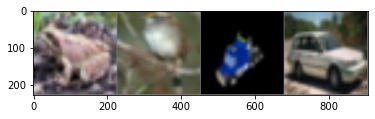

 frog  bird


In [6]:
# display some images

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Define model

In [7]:
device = "cuda:1"
x = torch.randn(2,3,224,224).to(device)
model = SimpleNet(3, 10).to(device)
output = model(x)
print(output.shape)

torch.Size([2, 10])


### Define Loss and optimizer

In [8]:
import torch.optim as optim

# define a loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### Training

In [9]:
### Train the network
print('Start Training ')
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # Fill this loop
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # print statistics
        if i % 50 == 0:
            print('[%d, %5d] loss: %.6f' %
                 (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

Start Training 
[1,     1] loss: 0.004960
[1,    51] loss: 0.231684
[1,   101] loss: 0.237043
[1,   151] loss: 0.227369
[1,   201] loss: 0.231986
[1,   251] loss: 0.231382
[1,   301] loss: 0.230739
[1,   351] loss: 0.228538
[1,   401] loss: 0.232580
[1,   451] loss: 0.222592
[1,   501] loss: 0.228729
[1,   551] loss: 0.223727
[1,   601] loss: 0.228592
[1,   651] loss: 0.224599
[1,   701] loss: 0.222358
[1,   751] loss: 0.223178
[1,   801] loss: 0.224089
[1,   851] loss: 0.223546
[1,   901] loss: 0.220411
[1,   951] loss: 0.221939
[1,  1001] loss: 0.220026
[1,  1051] loss: 0.224296
[1,  1101] loss: 0.218249
[1,  1151] loss: 0.220095
[1,  1201] loss: 0.219978
[1,  1251] loss: 0.218617
[1,  1301] loss: 0.217956
[1,  1351] loss: 0.222432
[1,  1401] loss: 0.218224
[1,  1451] loss: 0.215305
[1,  1501] loss: 0.215614
[1,  1551] loss: 0.218796
[1,  1601] loss: 0.216777
[1,  1651] loss: 0.214512
[1,  1701] loss: 0.218699
[1,  1751] loss: 0.218805
[1,  1801] loss: 0.219661
[1,  1851] loss: 0.216

KeyboardInterrupt: 

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

#print images
imshow(torchvision.utils.make_grid(images))
print('GrondTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(2)))

In [ ]:
images = images.to(device)
outputs = model(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(2))) 